In [111]:
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from Dataset import Dataset, ELM, device
torch.set_default_dtype(torch.float64)

In [112]:
x_data = np.float64(np.linspace(-15, 15, 600))
y_data = np.float64(np.sin(x_data) / x_data)
# y_data = np.float64(np.sin(x_data) / x_data + np.random.normal(0, 0.05, 600))

In [113]:
dataset = Dataset(x_data, y_data)
trainset1, trainset2, testset = torch.utils.data.random_split(dataset, [0.8, 0.1, 0.1])

activation = nn.LeakyReLU(negative_slope=0.1)
def inv_activation(x):
    return torch.min(x, 1/0.1*x)
# def activation(x):
#     return torch.max(x, 0.1*x)

In [114]:
class ELM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.act = nn.LeakyReLU(negative_slope=0.1)
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.fc2(x)
        return x

In [119]:
model = ELM(1, 100, 1).to(device)

V = activation(model.fc1.bias.data.reshape(-1, 1) + model.fc1.weight.data @ trainset1[:][0].reshape(1, -1).to(device))
H = torch.concatenate([torch.ones(1, len(trainset1)).to(device), V.to(device)], dim=0).T
W2 = torch.linalg.pinv(H) @ trainset1[:][1].to(device).reshape(1, -1, 1)
model.fc2.bias.data, model.fc2.weight.data = W2[0][0], W2[0][1:].T

torch.Size([480, 101])

In [121]:
V = inv_activation(torch.linalg.pinv(torch.concatenate([model.fc2.bias.data.reshape(-1, 1), model.fc2.weight.data], dim=1)) @ trainset1[:][1].reshape(1, -1).to(device)) 
H = V[1:, :] @ torch.linalg.pinv(torch.concatenate([torch.ones(1, len(trainset1)).to(device), trainset1[:][0].reshape(1, -1).to(device)], dim=0))
torch.concatenate([torch.ones(1, len(trainset1)).to(device), trainset1[:][0].reshape(1, -1).to(device)], dim=0).shape
model.fc1.bias.data, model.fc1.weight.data = H[:, 1], H[:, 0].reshape(-1, 1)

torch.Size([2, 480])

Train error: 15.432897349825259
Test error: 18.163568660505927


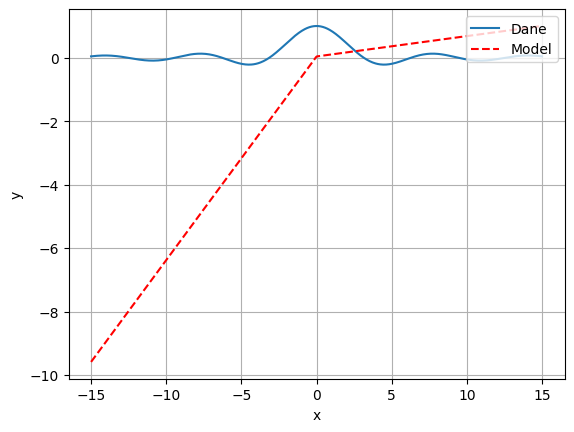

In [117]:
print(f'Train error: {(model(trainset1[:][0].clone().detach().reshape(-1, 1).to(device))-trainset1[:][1].reshape(-1, 1).to(device)).reshape(-1).pow(2).mean()}')
print(f'Test error: {(model(testset[:][0].clone().detach().reshape(-1, 1).to(device))-testset[:][1].reshape(-1, 1).to(device)).reshape(-1).pow(2).mean()}')
plt.plot(x_data, y_data)
plt.plot(x_data, model(torch.tensor(x_data).reshape(-1, 1).to(device)).cpu().detach().numpy(), 'r--')
plt.legend(['Dane', 'Model'], loc='upper right')
plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.show()

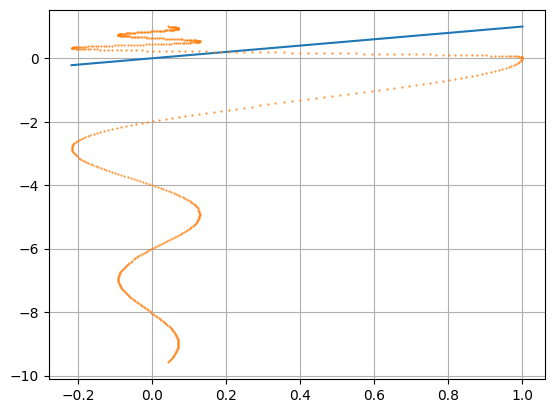

In [118]:
plt.plot([np.min(y_data), np.max(y_data)], [np.min(y_data), np.max(y_data)])
plt.plot(y_data, model(torch.tensor(x_data).reshape(-1, 1).to(device)).cpu().detach().numpy(), '.', markersize=1)
plt.grid()
plt.show()